In [3]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
Embeddings_UKB= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/epilepsy_PBS/Embeddings.csv")

In [5]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [6]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [7]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})
Embeddings_UKB  = Embeddings_UKB.rename(columns={Embeddings_UKB.columns[0]: "Index"})

In [8]:
mask= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/mask_interrupted_cs.csv")

In [9]:
mask=np.array(mask)

In [10]:
mask =mask.flatten()

In [11]:
Embeddings_interrupted_cs= Embeddings_UKB[mask]
Embeddings_UKB= Embeddings_UKB[~mask]

In [12]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
Embeddings_irm_negatives = Embeddings_epilepsy.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
Embeddings_irm_positives = Embeddings_epilepsy.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

In [13]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_irm_negatives.iloc[:,1:76]
X5= Embeddings_irm_positives.iloc[:,1:76]
X6= Embeddings_interrupted_cs.iloc[:,1:76]

In [14]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)
X5=scaler.transform(X5)
X6=scaler.transform(X6)

In [15]:
import statsmodels.api as sm

In [16]:
L= np.concatenate((X1,X2,X3,X4,X5,X6), axis=0)

covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*(len(X3)+len(X4)+len(X5)) 
            + ['UKB']*len(X6)
})


In [17]:
covariates = pd.get_dummies(covariates)


In [18]:
covariates_train= pd.concat([covariates.head(len(X1)+len(X2)+len(X3)), covariates.tail(len(X6))], ignore_index=True)
covariates_test= covariates.iloc[len(X1)+len(X2)+len(X3):len(X1)+len(X2)+len(X3)+len(X4)+len(X5)]

L_train=np.concatenate((X1,X2,X3,X6), axis=0)
L_test= np.concatenate((X4,X5), axis=0)

In [19]:
covariates = sm.add_constant(covariates)  # Add intercept

L1_resid = np.zeros_like(L_train)
L2_resid = np.zeros_like(L_test)

for j in range(L_train.shape[1]):
    model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
    L1_resid[:, j] = model.resid 
    L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)


In [20]:
X_ukb = L1_resid[:len(X1),:]
X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X_neg= L2_resid[:len(X4),:]
X_pos=L2_resid[len(X4):,:]
X_cs=L1_resid[len(X1)+len(X2)+len(X3):,:]

In [21]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

In [22]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap2 = reducer.fit_transform(X_ukb)
X2_umap2 = reducer.transform(X_hcp)
X3_umap2= reducer.transform(X_control)
X4_umap2=reducer.transform(X_neg)
X5_umap2=reducer.transform(X_pos)
X6_umap2=reducer.transform(X_cs)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Full latent space

LOF

In [23]:
from sklearn.neighbors import LocalOutlierFactor

In [24]:
lof = LocalOutlierFactor(contamination=0.28, novelty=True)
lof.fit(X_ukb)
y1 = lof.predict(X_ukb)
y2 = lof.predict(X_hcp)
y3 = lof.predict(X_control)
y4 = lof.predict(X_neg)
y5 = lof.predict(X_pos)
y6 = lof.predict(X_cs)

In [25]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')
print(f'interrupted_cs :{proportion_positive(y6)}')

UKB :0.7405153223132667
HCP :0.8913824057450629
Control :1.0
irm_neg :0.6923076923076923
irm_pos :0.4
interrupted_cs :0.6473429951690821


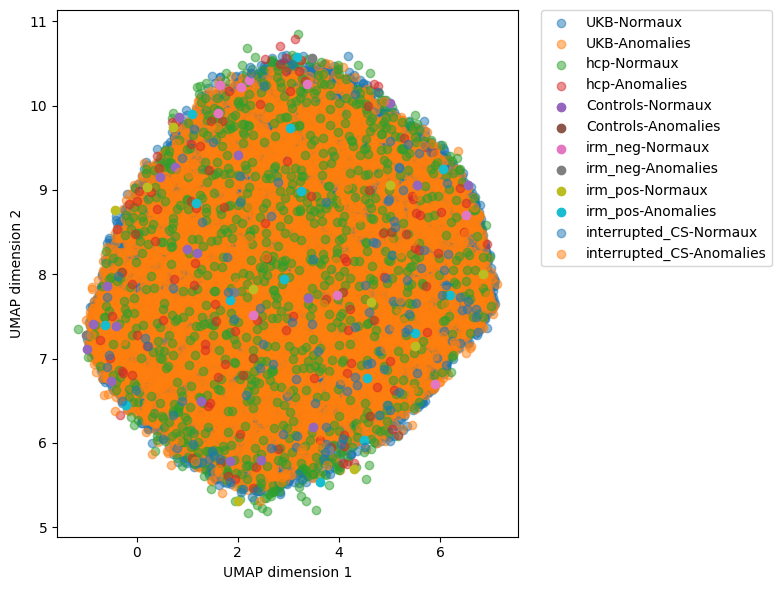

In [36]:
plt.figure(figsize=(8, 6))


# X_ukb
plt.scatter(
    X1_umap2[y1 == 1, 0],
    X1_umap2[y1 == 1, 1],
    label="UKB-Normaux", alpha=0.5
) 
plt.scatter(
    X1_umap2[y1 == -1, 0],
    X1_umap2[y1 == -1, 1],
    label="UKB-Anomalies", alpha=0.5
)

# X_hcp
plt.scatter(
    X2_umap2[y2 == 1, 0],
    X2_umap2[y2 == 1, 1],
    label="hcp-Normaux", alpha=0.5
)
plt.scatter(
    X2_umap2[y2 == -1, 0],
    X2_umap2[y2 == -1, 1],
    label="hcp-Anomalies", alpha=0.5
)

# X_control
plt.scatter(
    X3_umap2[y3 == 1, 0],
    X3_umap2[y3 == 1, 1],
    label="Controls-Normaux"
)
plt.scatter(
    X3_umap2[y3 == -1, 0],
    X3_umap2[y3 == -1, 1],
    label="Controls-Anomalies"
)

# X_neg
plt.scatter(
    X4_umap2[y4 == 1, 0],
    X4_umap2[y4 == 1, 1],
    label="irm_neg-Normaux"
)
plt.scatter(
    X4_umap2[y4 == -1, 0],
    X4_umap2[y4 == -1, 1],
    label="irm_neg-Anomalies"
)

# X_pos
plt.scatter(
    X5_umap2[y5 == 1, 0],
    X5_umap2[y5 == 1, 1],
    label="irm_pos-Normaux"
)
plt.scatter(
    X5_umap2[y5 == -1, 0],
    X5_umap2[y5 == -1, 1],
    label="irm_pos-Anomalies"
)

# X_cs
plt.scatter(
    X6_umap2[y6 == 1, 0],
    X6_umap2[y6 == 1, 1],
    label="interrupted_CS-Normaux", alpha=0.5
)
plt.scatter(
    X6_umap2[y6 == -1, 0],
    X6_umap2[y6 == -1, 1],
    label="interrupted_CS-Anomalies", alpha=0.5
)

plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

UMAP 2D

In [37]:
from sklearn.svm import OneClassSVM

In [39]:
clf = OneClassSVM(kernel='rbf',nu=0.1)
clf.fit(X1_umap2)

y1 = clf.predict(X1_umap2)
y2 = clf.predict(X2_umap2)
y3 = clf.predict(X3_umap2)
y4 = clf.predict(X4_umap2)
y5 = clf.predict(X5_umap2)
y6 = clf.predict(X6_umap2)

In [40]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')
print(f'interrupted_cs :{proportion_positive(y6)}')

UKB :0.9000378913465638
HCP :0.7217235188509874
Control :0.631578947368421
irm_neg :0.23076923076923078
irm_pos :0.52
interrupted_cs :0.6763285024154589


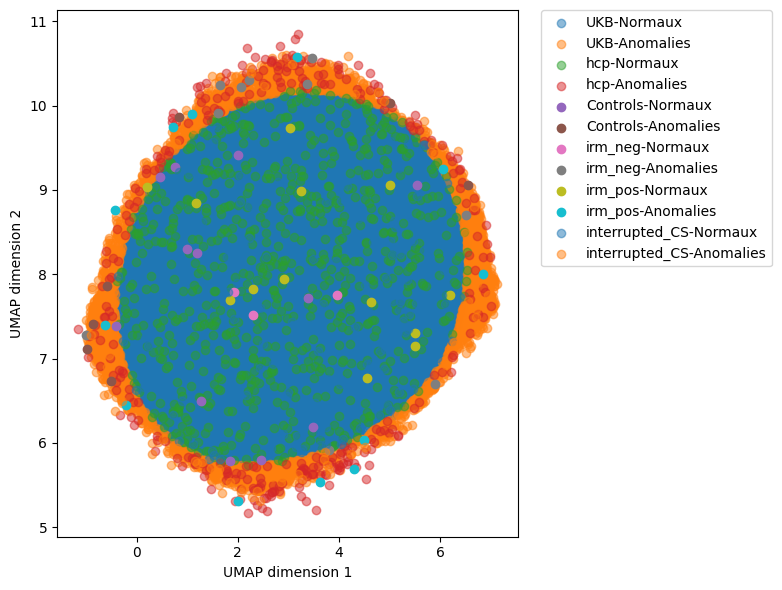

In [41]:
plt.figure(figsize=(8, 6))


# X_ukb
plt.scatter(
    X1_umap2[y1 == 1, 0],
    X1_umap2[y1 == 1, 1],
    label="UKB-Normaux", alpha=0.5
) 
plt.scatter(
    X1_umap2[y1 == -1, 0],
    X1_umap2[y1 == -1, 1],
    label="UKB-Anomalies", alpha=0.5
)

# X_hcp
plt.scatter(
    X2_umap2[y2 == 1, 0],
    X2_umap2[y2 == 1, 1],
    label="hcp-Normaux", alpha=0.5
)
plt.scatter(
    X2_umap2[y2 == -1, 0],
    X2_umap2[y2 == -1, 1],
    label="hcp-Anomalies", alpha=0.5
)

# X_control
plt.scatter(
    X3_umap2[y3 == 1, 0],
    X3_umap2[y3 == 1, 1],
    label="Controls-Normaux"
)
plt.scatter(
    X3_umap2[y3 == -1, 0],
    X3_umap2[y3 == -1, 1],
    label="Controls-Anomalies"
)

# X_neg
plt.scatter(
    X4_umap2[y4 == 1, 0],
    X4_umap2[y4 == 1, 1],
    label="irm_neg-Normaux"
)
plt.scatter(
    X4_umap2[y4 == -1, 0],
    X4_umap2[y4 == -1, 1],
    label="irm_neg-Anomalies"
)

# X_pos
plt.scatter(
    X5_umap2[y5 == 1, 0],
    X5_umap2[y5 == 1, 1],
    label="irm_pos-Normaux"
)
plt.scatter(
    X5_umap2[y5 == -1, 0],
    X5_umap2[y5 == -1, 1],
    label="irm_pos-Anomalies"
)

# X_cs
plt.scatter(
    X6_umap2[y6 == 1, 0],
    X6_umap2[y6 == 1, 1],
    label="interrupted_CS-Normaux", alpha=0.5
)
plt.scatter(
    X6_umap2[y6 == -1, 0],
    X6_umap2[y6 == -1, 1],
    label="interrupted_CS-Anomalies", alpha=0.5
)

plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.ensemble import IsolationForest

In [43]:
clf = IsolationForest(contamination=0.14, random_state=42)
clf.fit(X1_umap2)

y1 = clf.predict(X1_umap2)
y2 = clf.predict(X2_umap2)
y3 = clf.predict(X3_umap2)
y4 = clf.predict(X4_umap2)
y5 = clf.predict(X5_umap2)
y6 = clf.predict(X6_umap2)

In [44]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')
print(f'interrupted_cs :{proportion_positive(y6)}')

UKB :0.8599914744470232
HCP :0.6409335727109515
Control :0.5263157894736842
irm_neg :0.23076923076923078
irm_pos :0.48
interrupted_cs :0.6038647342995169


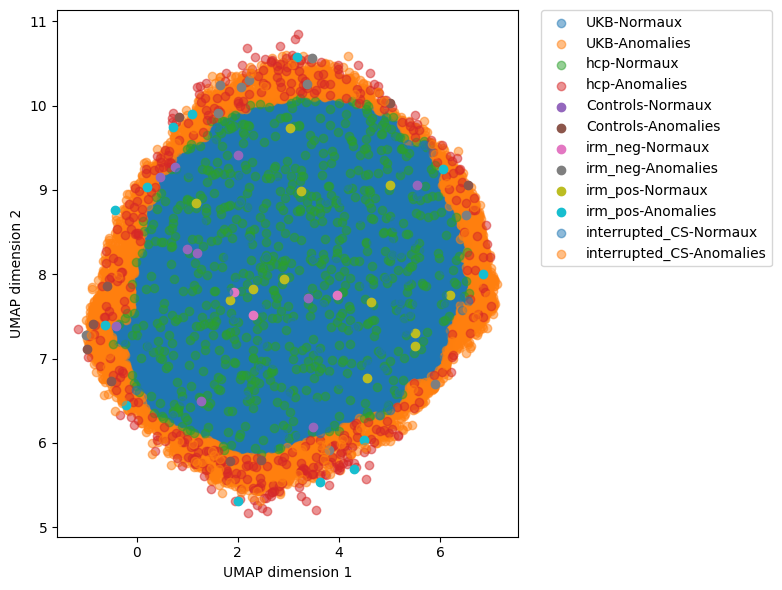

In [45]:
plt.figure(figsize=(8, 6))


# X_ukb
plt.scatter(
    X1_umap2[y1 == 1, 0],
    X1_umap2[y1 == 1, 1],
    label="UKB-Normaux", alpha=0.5
) 
plt.scatter(
    X1_umap2[y1 == -1, 0],
    X1_umap2[y1 == -1, 1],
    label="UKB-Anomalies", alpha=0.5
)

# X_hcp
plt.scatter(
    X2_umap2[y2 == 1, 0],
    X2_umap2[y2 == 1, 1],
    label="hcp-Normaux", alpha=0.5
)
plt.scatter(
    X2_umap2[y2 == -1, 0],
    X2_umap2[y2 == -1, 1],
    label="hcp-Anomalies", alpha=0.5
)

# X_control
plt.scatter(
    X3_umap2[y3 == 1, 0],
    X3_umap2[y3 == 1, 1],
    label="Controls-Normaux"
)
plt.scatter(
    X3_umap2[y3 == -1, 0],
    X3_umap2[y3 == -1, 1],
    label="Controls-Anomalies"
)

# X_neg
plt.scatter(
    X4_umap2[y4 == 1, 0],
    X4_umap2[y4 == 1, 1],
    label="irm_neg-Normaux"
)
plt.scatter(
    X4_umap2[y4 == -1, 0],
    X4_umap2[y4 == -1, 1],
    label="irm_neg-Anomalies"
)

# X_pos
plt.scatter(
    X5_umap2[y5 == 1, 0],
    X5_umap2[y5 == 1, 1],
    label="irm_pos-Normaux"
)
plt.scatter(
    X5_umap2[y5 == -1, 0],
    X5_umap2[y5 == -1, 1],
    label="irm_pos-Anomalies"
)

# X_cs
plt.scatter(
    X6_umap2[y6 == 1, 0],
    X6_umap2[y6 == 1, 1],
    label="interrupted_CS-Normaux", alpha=0.5
)
plt.scatter(
    X6_umap2[y6 == -1, 0],
    X6_umap2[y6 == -1, 1],
    label="interrupted_CS-Anomalies", alpha=0.5
)

plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [23]:
from pyod.models.abod import ABOD

In [24]:
clf = ABOD(contamination=0.06)
clf.fit(X1_umap2)

y1 = 1- clf.predict(X1_umap2)
y2 = 1 -clf.predict(X2_umap2)
y3 = 1 -clf.predict(X3_umap2)
y4 = 1- clf.predict(X4_umap2)
y5 = 1- clf.predict(X5_umap2)
y6 = 1- clf.predict(X6_umap2)

In [25]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')
print(f'interrupted_cs :{proportion_positive(y6)}')

UKB :0.9352294794676266
HCP :0.7881508078994613
Control :0.8421052631578947
irm_neg :0.46153846153846156
irm_pos :0.64
interrupted_cs :0.7632850241545893


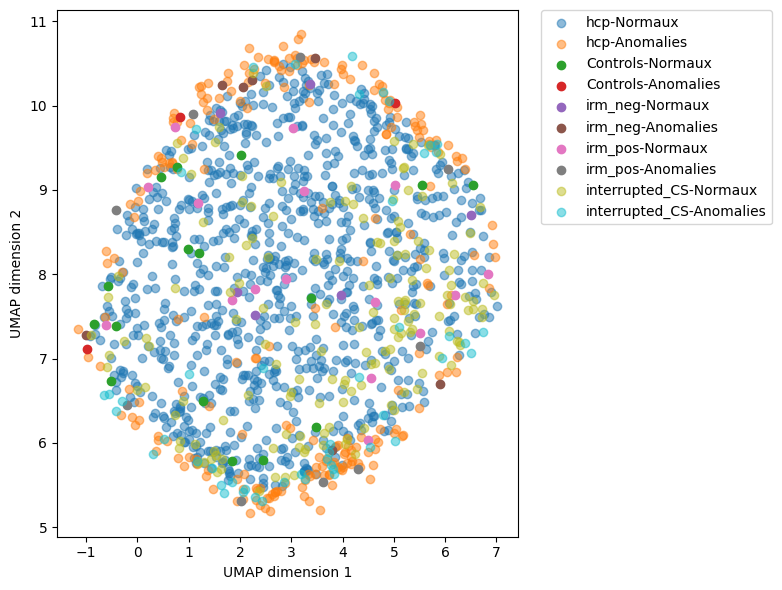

In [27]:
plt.figure(figsize=(8, 6))

'''
# X_ukb
plt.scatter(
    X1_umap2[y1 == 1, 0],
    X1_umap2[y1 == 1, 1],
    label="UKB-Normaux", alpha=0.5
) 
plt.scatter(
    X1_umap2[y1 == 0, 0],
    X1_umap2[y1 == 0, 1],
    label="UKB-Anomalies", alpha=0.5
)'''

# X_hcp
plt.scatter(
    X2_umap2[y2 == 1, 0],
    X2_umap2[y2 == 1, 1],
    label="hcp-Normaux", alpha=0.5
)
plt.scatter(
    X2_umap2[y2 == 0, 0],
    X2_umap2[y2 == 0, 1],
    label="hcp-Anomalies", alpha=0.5
)

# X_control
plt.scatter(
    X3_umap2[y3 == 1, 0],
    X3_umap2[y3 == 1, 1],
    label="Controls-Normaux"
)
plt.scatter(
    X3_umap2[y3 == 0, 0],
    X3_umap2[y3 == 0, 1],
    label="Controls-Anomalies"
)

# X_neg
plt.scatter(
    X4_umap2[y4 == 1, 0],
    X4_umap2[y4 == 1, 1],
    label="irm_neg-Normaux"
)
plt.scatter(
    X4_umap2[y4 == 0, 0],
    X4_umap2[y4 == 0, 1],
    label="irm_neg-Anomalies"
)

# X_pos
plt.scatter(
    X5_umap2[y5 == 1, 0],
    X5_umap2[y5 == 1, 1],
    label="irm_pos-Normaux"
)
plt.scatter(
    X5_umap2[y5 == 0, 0],
    X5_umap2[y5 == 0, 1],
    label="irm_pos-Anomalies"
)

# X_cs
plt.scatter(
    X6_umap2[y6 == 1, 0],
    X6_umap2[y6 == 1, 1],
    label="interrupted_CS-Normaux", alpha=0.5
)
plt.scatter(
    X6_umap2[y6 == 0, 0],
    X6_umap2[y6 == 0, 1],
    label="interrupted_CS-Anomalies", alpha=0.5
)

plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Umap 40D

In [28]:
reducer = umap.UMAP(n_components=40, random_state=42)
X1_umap40 = reducer.fit_transform(X_ukb)
X2_umap40 = reducer.transform(X_hcp)
X3_umap40= reducer.transform(X_control)
X4_umap40=reducer.transform(X_neg)
X5_umap40=reducer.transform(X_pos)
X6_umap40=reducer.transform(X_cs)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
clf = IsolationForest(contamination=0.12, random_state=42)
clf.fit(X1_umap40)

y1 = clf.predict(X1_umap40)
y2 = clf.predict(X2_umap40)
y3 = clf.predict(X3_umap40)
y4 = clf.predict(X4_umap40)
y5 = clf.predict(X5_umap40)
y6 = clf.predict(X6_umap40)

In [32]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')
print(f'irm_pos :{proportion_positive(y5)}')
print(f'interrupted_cs :{proportion_positive(y6)}')

UKB :0.8800028418509923
HCP :0.5377019748653501
Control :0.631578947368421
irm_neg :0.38461538461538464
irm_pos :0.2
interrupted_cs :0.5072463768115942


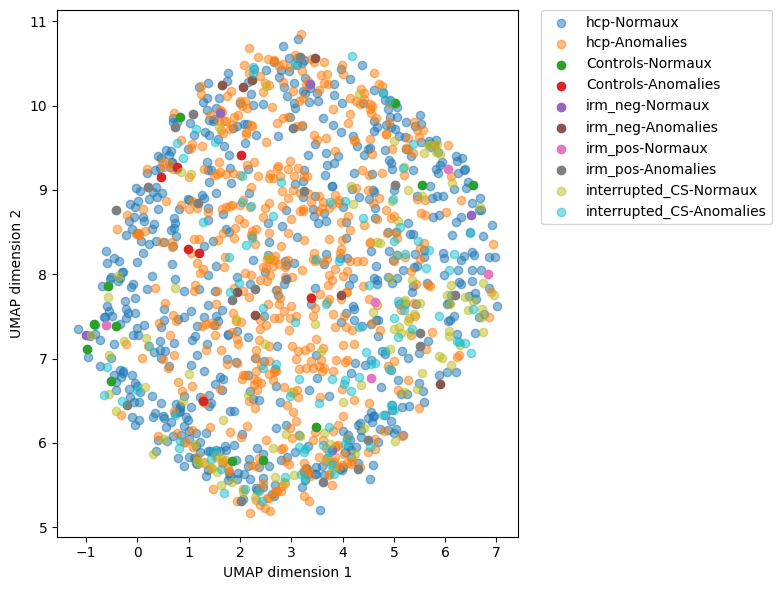

In [36]:
plt.figure(figsize=(8, 6))

'''
# X_ukb
plt.scatter(
    X1_umap2[y1 == 1, 0],
    X1_umap2[y1 == 1, 1],
    label="UKB-Normaux", alpha=0.5
) 
plt.scatter(
    X1_umap2[y1 == -1, 0],
    X1_umap2[y1 == -1, 1],
    label="UKB-Anomalies", alpha=0.5
)'''

# X_hcp
plt.scatter(
    X2_umap2[y2 == 1, 0],
    X2_umap2[y2 == 1, 1],
    label="hcp-Normaux", alpha=0.5
)
plt.scatter(
    X2_umap2[y2 == -1, 0],
    X2_umap2[y2 == -1, 1],
    label="hcp-Anomalies", alpha=0.5
)

# X_control
plt.scatter(
    X3_umap2[y3 == 1, 0],
    X3_umap2[y3 == 1, 1],
    label="Controls-Normaux"
)
plt.scatter(
    X3_umap2[y3 == -1, 0],
    X3_umap2[y3 == -1, 1],
    label="Controls-Anomalies"
)

# X_neg
plt.scatter(
    X4_umap2[y4 == 1, 0],
    X4_umap2[y4 == 1, 1],
    label="irm_neg-Normaux"
)
plt.scatter(
    X4_umap2[y4 == -1, 0],
    X4_umap2[y4 == -1, 1],
    label="irm_neg-Anomalies"
)

# X_pos
plt.scatter(
    X5_umap2[y5 == 1, 0],
    X5_umap2[y5 == 1, 1],
    label="irm_pos-Normaux"
)
plt.scatter(
    X5_umap2[y5 == -1, 0],
    X5_umap2[y5 == -1, 1],
    label="irm_pos-Anomalies"
)

# X_cs
plt.scatter(
    X6_umap2[y6 == 1, 0],
    X6_umap2[y6 == 1, 1],
    label="interrupted_CS-Normaux", alpha=0.5
)
plt.scatter(
    X6_umap2[y6 == -1, 0],
    X6_umap2[y6 == -1, 1],
    label="interrupted_CS-Anomalies", alpha=0.5
)

plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()